<a href="https://colab.research.google.com/github/vyshnavi-2/Fairness-Auditing-In-ML/blob/main/Fairness_Detection_in_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Project: Fairness Detection in Machine Learning                                                                        
Dataset: UCI Adult Income Dataset                                                                                                                                                                                              
Objective: Train models while ensuring fairness using reweighing and evaluate performance.

Key Steps:
1. Load and preprocess the data
2. Apply fairness reweighing technique
3. Train multiple models with weighted samples
4. Evaluate accuracy and fairness metrics
5. Visualize results using graphs

In [ ]:
#Installing the required libraries
!pip install aif360 #used for bias mitigation and fairness evaluation


In [ ]:
#importing the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from aif360.algorithms.preprocessing import Reweighing
from aif360.datasets import StandardDataset


In [ ]:
# Load dataset
columns = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
           "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss",
           "hours-per-week", "native-country", "income"]

df = pd.read_csv("/content/adult.data", names=columns, sep=",\s", na_values="?", engine='python')
df_test = pd.read_csv("/content/adult.test", names=columns, sep=",\s", na_values="?", engine='python', skiprows=1)

In [ ]:
# Drop missing values
df.dropna(inplace=True)
df_test.dropna(inplace=True)

In [ ]:
# Fix income labels
df["income"] = df["income"].str.strip().replace({">50K.": ">50K", "<=50K.": "<=50K"})
df_test["income"] = df_test["income"].str.strip().replace({">50K.": ">50K", "<=50K.": "<=50K"})

In [ ]:
# Convert categorical variables
categorical_columns = ["workclass", "education", "marital-status", "occupation",
                       "relationship", "race", "sex", "native-country", "income"]

label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    df_test[col] = le.transform(df_test[col])
    label_encoders[col] = le

In [ ]:
# Extract sensitive attributes
df["sex_binary"] = df["sex"].map({1: 1, 0: 0})  # 1 = Male, 0 = Female
df["race_binary"] = df["race"].apply(lambda x: 1 if x == 4 else 0)  # 1 = White, 0 = Non-White

df_test["sex_binary"] = df_test["sex"].map({1: 1, 0: 0})
df_test["race_binary"] = df_test["race"].apply(lambda x: 1 if x == 4 else 0)

In [ ]:
# Prepare features and target
X = df.drop(columns=["income"])
y = df["income"]

X_test = df_test.drop(columns=["income"])
y_test = df_test["income"]

In [ ]:
# Normalize data
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_test = scaler.transform(X_test)

In [ ]:
# Stratified split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
train_df = pd.DataFrame(X_train, columns=[f"feature_{i}" for i in range(X_train.shape[1])])
train_df["income"] = y_train.values
train_df["sex_binary"] = df.loc[y_train.index, "sex_binary"].values
train_df["race_binary"] = df.loc[y_train.index, "race_binary"].values
dataset_train = StandardDataset(train_df,
                                label_name="income",
                                favorable_classes=[1],
                                protected_attribute_names=["sex_binary"],
                                privileged_classes=[[1]])

In [ ]:
# Apply reweighing to balance bias
reweigher = Reweighing(unprivileged_groups=[{"sex_binary": 0}], privileged_groups=[{"sex_binary": 1}])
dataset_transf_train = reweigher.fit_transform(dataset_train)
sample_weights = dataset_transf_train.instance_weights

In [ ]:
# Debugging sample_weights shape
print("Shape of sample_weights before fix:", sample_weights.shape)
print("Shape of y_train:", y_train.shape)
if sample_weights.shape[0] != y_train.shape[0]:
    print("Mismatch detected! Reshaping sample_weights...")
    sample_weights = sample_weights.ravel()  # Convert to 1D

print("Fixed sample_weights shape:", sample_weights.shape)


Shape of sample_weights before fix: (24129,)
Shape of y_train: (24129,)
Fixed sample_weights shape: (24129,)


In [ ]:
# Train Models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss")
}

results = {}

for model_name, model in models.items():
    model.fit(X_train, y_train, sample_weight=sample_weights)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    results[model_name] = (acc, report, conf_matrix)
    print(f"\n{model_name} Accuracy: {acc:.4f}")
    print(report)
    print("Confusion Matrix:\n", conf_matrix)



Logistic Regression Accuracy: 0.8068
              precision    recall  f1-score   support

           0       0.83      0.94      0.88     11360
           1       0.69      0.39      0.50      3700

    accuracy                           0.81     15060
   macro avg       0.76      0.67      0.69     15060
weighted avg       0.79      0.81      0.79     15060

Confusion Matrix:
 [[10694   666]
 [ 2244  1456]]

Random Forest Accuracy: 0.8492
              precision    recall  f1-score   support

           0       0.88      0.93      0.90     11360
           1       0.73      0.61      0.67      3700

    accuracy                           0.85     15060
   macro avg       0.81      0.77      0.78     15060
weighted avg       0.84      0.85      0.84     15060

Confusion Matrix:
 [[10520   840]
 [ 1431  2269]]


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:04:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Accuracy: 0.8631
              precision    recall  f1-score   support

           0       0.88      0.94      0.91     11360
           1       0.78      0.62      0.69      3700

    accuracy                           0.86     15060
   macro avg       0.83      0.78      0.80     15060
weighted avg       0.86      0.86      0.86     15060

Confusion Matrix:
 [[10713   647]
 [ 1415  2285]]


In [ ]:
# Fairness Metrics Calculation
def fairness_metrics(y_pred, sensitive_series):
    privileged = np.mean(y_pred[sensitive_series == 1])
    unprivileged = np.mean(y_pred[sensitive_series == 0])

    disparate_impact = unprivileged / privileged if privileged > 0 else 0
    statistical_parity = unprivileged - privileged

    return disparate_impact, statistical_parity


In [ ]:
# Gender Fairness (Female vs Male)
gender_disparate_impact, gender_statistical_parity = fairness_metrics(y_pred, df_test["sex_binary"])

# Race Fairness (Non-White vs White)
race_disparate_impact, race_statistical_parity = fairness_metrics(y_pred, df_test["race_binary"])


In [ ]:
print(f"\nDisparate Impact (Gender - Female vs Male): {gender_disparate_impact:.4f}")
print(f"Statistical Parity (Gender - Female vs Male): {gender_statistical_parity:.4f}")

print(f"\nDisparate Impact (Race - Non-White vs White): {race_disparate_impact:.4f}")
print(f"Statistical Parity (Race - Non-White vs White): {race_statistical_parity:.4f}")


Disparate Impact (Gender - Female vs Male): 0.5292
Statistical Parity (Gender - Female vs Male): -0.1083

Disparate Impact (Race - Non-White vs White): 0.5785
Statistical Parity (Race - Non-White vs White): -0.0872


Bar Plot for Model Accuracy

<ipython-input-109-6fc52e4b36aa>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=accuracies, palette="viridis")


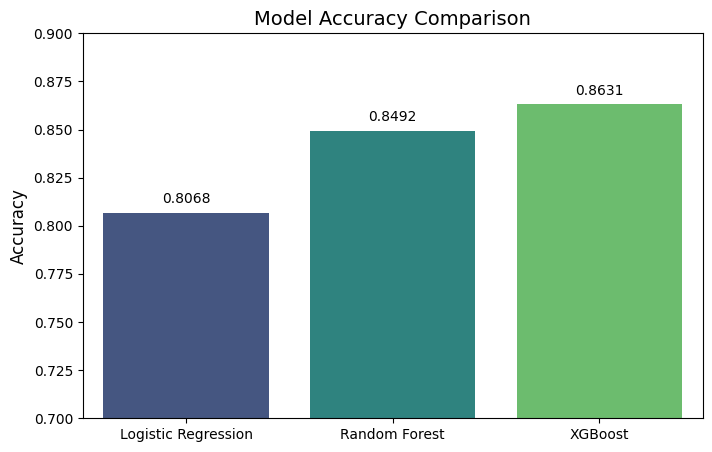

In [ ]:
model_names = list(results.keys())
accuracies = [results[model][0] for model in model_names]
plt.figure(figsize=(8, 5))
sns.barplot(x=model_names, y=accuracies, palette="viridis")
plt.title("Model Accuracy Comparison", fontsize=14)
plt.ylabel("Accuracy", fontsize=12)
plt.ylim(0.7, 0.9)
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.005, f"{acc:.4f}", ha='center', fontsize=10)

plt.show()


Confusion Matrix Heatmap

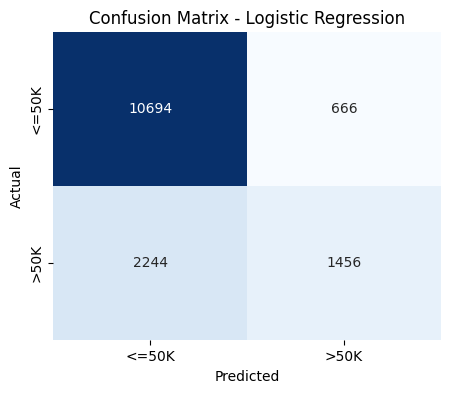

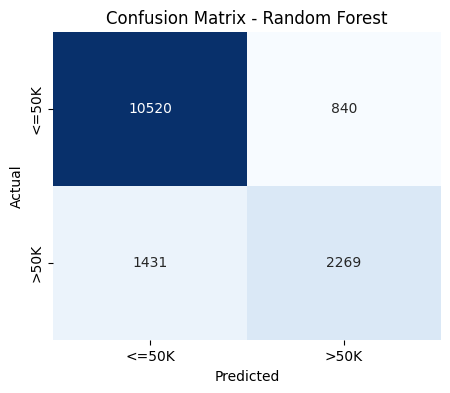

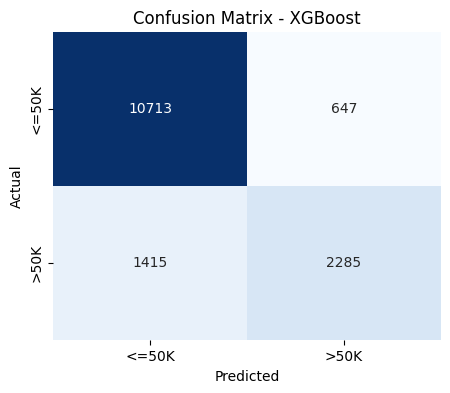

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
for model_name, (_, _, conf_matrix) in results.items():
    plt.figure(figsize=(5, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=["<=50K", ">50K"], yticklabels=["<=50K", ">50K"])
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


Fairness Metric Visualization

<ipython-input-111-42f06d75cb1f>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=categories, y=values, palette="coolwarm")


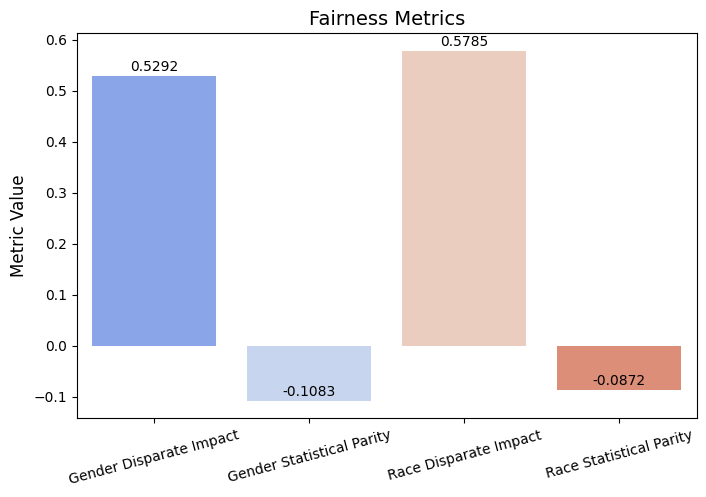

In [ ]:
# Fairness metrics for gender and race
categories = ["Gender Disparate Impact", "Gender Statistical Parity", "Race Disparate Impact", "Race Statistical Parity"]
values = [gender_disparate_impact, gender_statistical_parity, race_disparate_impact, race_statistical_parity]

plt.figure(figsize=(8, 5))
sns.barplot(x=categories, y=values, palette="coolwarm")

plt.title("Fairness Metrics", fontsize=14)
plt.ylabel("Metric Value", fontsize=12)
plt.xticks(rotation=15)

for i, val in enumerate(values):
    plt.text(i, val + 0.01, f"{val:.4f}", ha='center', fontsize=10)

plt.show()
